### Libraries


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout, MaxPooling2D, Reshape, Concatenate, Input, BatchNormalization, ZeroPadding2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import math
import seaborn as sns


from tensorflow import keras
from tensorflow.keras import Model
from keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight


### SPP function

In [ ]:
def spp_layer(prev_conv, numb_batch, prev_conv_size, levels):
    """
    prev_conv: output of last convolutional layer
    numb_batch: number of images per batch
    pre_conv_size: size of the output from last convolutional layer
    levels: list of bins from SPP
    """
    block=0
    #spp = None  # Initialize spp
    for level in levels:
        block=1+block
        h_wid=int(math.ceil(prev_conv_size[0]/level))     #Heigth window calculation
        w_wid=int(math.ceil(prev_conv_size[1]/level))     #Width window calculation
        h_pad=int((h_wid*level-prev_conv_size[0]+1)//2)    #Heigth padding calculation
        w_pad=int((w_wid*level-prev_conv_size[1]+1)//2)    #Width padding calculation

        padding_layer = ZeroPadding2D(padding=((h_pad, h_pad), (w_pad, w_pad)), name=f'block{block}_zero_pad{level}')(prev_conv) #adjusts the padding to (h_pad, w_pad)
        maxpool=MaxPooling2D(pool_size = (h_wid, w_wid),  #Maxpooling operation
                             strides = (h_wid, w_wid),
                             padding = "valid",
                             name=f'block{block}_pooling{level}')(padding_layer)           #It should respect the padding from ZeroPadding

        bn_layer  = BatchNormalization(name=f'block{block}_batch_normalization{level}')(maxpool)
        #x_reshaped = Reshape((numb_batch, -1))(x)         #Reshapes last layer to [numb_batch x last dimension]

        if level == 4:
          spp=Reshape((numb_batch, -1), name=f'block{block}_reshape_spp')(bn_layer)
          print("spp1",spp.shape)
        else:
          spp = Concatenate(axis=2, name=f'block{block}_concatenate{level}')([spp, Reshape((numb_batch, -1), name=f'block{block}_reshape{level}')(bn_layer)])    #Concatenate spp with x_reshaped
          print("spp2", spp.shape)
    return spp

levels=[4, 2, 1]                                          #Levels of SPP

### Loading Data


In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
train_data_dir = "/content/drive/MyDrive/SAR_RGB/RGB/train"
validation_data_dir = "/content/drive/MyDrive/SAR_RGB/RGB/val"
num_classes = 4
img_width, img_height = 224, 224  # VGGNet requires input images to be 224x224 pixels

In [ ]:
# Define data generators for training and validation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.5, 1.7]
)

validation_datagen = ImageDataGenerator(rescale=1.0/255.0)

### Model and data

In [ ]:
batch_size = 32

# Load pre-trained VGG16 model without top (fully connected) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

base_model.summary()

# Fine-Tune
for layer in base_model.layers[-1:]:
    layer.trainable = True

# Add SPP layer on top of VGG16
x = spp_layer(base_model.output, batch_size, base_model.output_shape[1:3], levels)

# Add fully connected layers
x = Flatten()(x)
x = BatchNormalization(name='batch_normalization_top')(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout layer
x = BatchNormalization(name='batch_normalization_bot')(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout layer
x = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=x)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

spp1 (None, 32, 256)
spp2 (None, 32, 320)
spp2 (None, 32, 336)


In [ ]:
#Learning rate
new_learning_rate = 0.0005
new_optimizer = Adam(learning_rate=new_learning_rate)

# Compile the model
model.compile(optimizer=new_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle = True,  # shuffle the data, default is true but just to point it out
)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle = True,  # shuffle the data, default is true but just to point it out
)

#####
train_classes=train_generator.classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_classes), y=train_classes)
class_weights_dict = dict(zip(np.unique(train_classes), class_weights))
class_weights = class_weights_dict
#####

Found 14400 images belonging to 4 classes.
Found 1440 images belonging to 4 classes.


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 224, 224, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 224, 224, 64)   │         36,928 │ block1_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_pool               │ (None, 112, 112, 64)   │              0 │ block1_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv1 (Conv2D)     │ (None, 112, 112, 128)  │         73,856 │ block1_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv2 (Conv2D)     │ (None, 112, 112, 128)  │        147,584 │ block2_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 56, 56, 128)    │              0 │ block2_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv1 (Conv2D)     │ (None, 56, 56, 256)    │        295,168 │ block2_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv2 (Conv2D)     │ (None, 56, 56, 256)    │        590,080 │ block3_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv3 (Conv2D)     │ (None, 56, 56, 256)    │        590,080 │ block3_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_pool               │ (None, 28, 28, 256)    │              0 │ block3_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv1 (Conv2D)     │ (None, 28, 28, 512)    │      1,180,160 │ block3_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv2 (Conv2D)     │ (None, 28, 28, 512)    │      2,359,808 │ block4_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv3 (Conv2D)     │ (None, 28, 28, 512)    │      2,359,808 │ block4_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_pool               │ (None, 14, 14, 512)    │              0 │ block4_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv1 (Conv2D)     │ (None, 14, 14, 512)    │      2,359,808 │ block4_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv2 (Conv2D)     │ (None, 14, 14, 512)    │      2,359,808 │ block5_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv3 (Conv2D)

 Total params: 26,305,860 (100.35 MB)

 Trainable params: 26,279,236 (100.25 MB)

 Non-trainable params: 26,624 (104.00 KB)

In [ ]:
steps_per_epoch = train_generator.samples // batch_size
validation_steps = validation_generator.samples // batch_size
print(f'Steps per epoch: {steps_per_epoch}')
print(f'Validation steps: {validation_steps}')

Steps per epoch: 450
Validation steps: 45


### Training

In [ ]:
# Train the model
epochs = 100  # You can increase this for better performance
checkpoint = ModelCheckpoint("RGB_model.keras", monitor="val_accuracy", save_best_only=True, mode="max")
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)
#LearningRateScheduler callback
#lr_scheduler = LearningRateScheduler(learning_rate_schedule)
steps_per_epoch = train_generator.samples // batch_size
validation_steps = validation_generator.samples // batch_size

history = model.fit(
    train_generator,
    #steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    #validation_steps=validation_generator.samples // batch_size,
    callbacks=[checkpoint, early_stopping],
    class_weight=class_weights
)

# Save the model
model.save('RGB_model.keras')

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


450/450 ━━━━━━━━━━━━━━━━━━━━ 4475s 10s/step - accuracy: 0.5276 - loss: 1.1825 - val_accuracy: 0.4028 - val_loss: 23.0228
Epoch 2/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 377s 828ms/step - accuracy: 0.8225 - loss: 0.5034 - val_accuracy: 0.6090 - val_loss: 1.0456
Epoch 3/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 379s 820ms/step - accuracy: 0.8753 - loss: 0.3561 - val_accuracy: 0.9215 - val_loss: 0.2635
Epoch 4/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 367s 804ms/step - accuracy: 0.9107 - loss: 0.2604 - val_accuracy: 0.9694 - val_loss: 0.0990
Epoch 5/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 378s 795ms/step - accuracy: 0.9524 - loss: 0.1424 - val_accuracy: 0.9278 - val_loss: 0.2672
Epoch 6/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 382s 798ms/step - accuracy: 0.9473 - loss: 0.1688 - val_accuracy: 0.9493 - val_loss: 0.1333
Epoch 7/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 384s 803ms/step - accuracy: 0.9673 - loss: 0.1096 - val_accuracy: 0.9868 - val_loss: 0.0686
Epoch 8/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 367s 804ms/step - accuracy: 0.9628 - los

### Accuracy and Loss

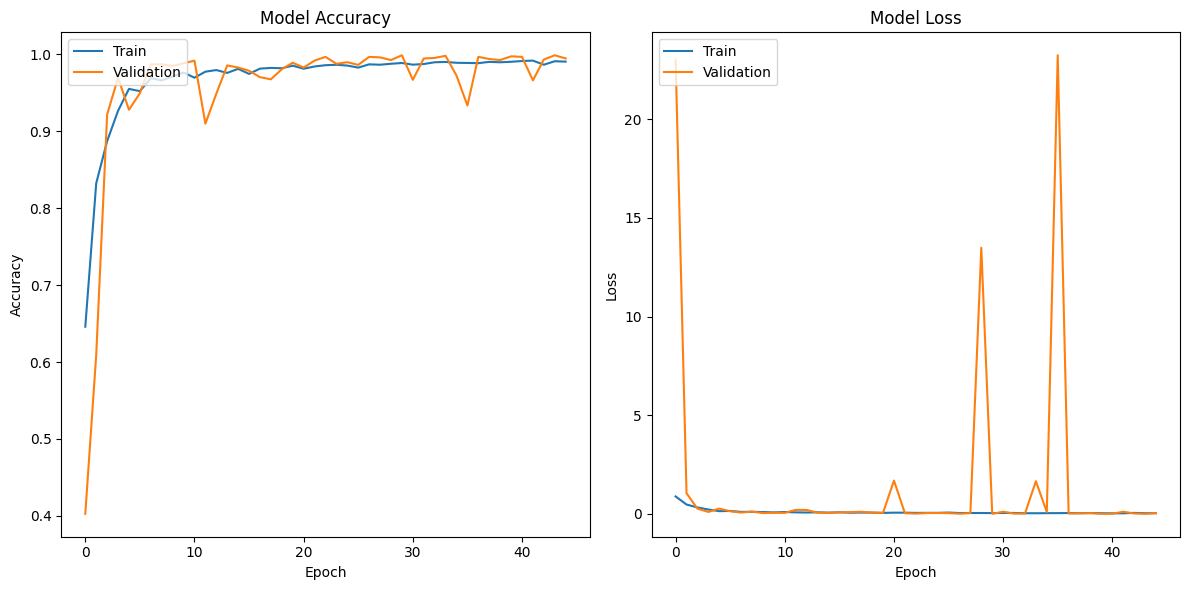

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

### Confusion Matrix


In [ ]:
from tensorflow.keras.models import load_model

#Load Model
model = load_model('RGB_model.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


45/45 ━━━━━━━━━━━━━━━━━━━━ 791s 18s/step
Class Indices in validation_generator.classes: [0 1 2 3]
Class Labels: ['agri', 'barrenland', 'grassland', 'urban']
Class Labels in Heatmap: [Text(0.5, 0, 'agri'), Text(1.5, 0, 'barrenland'), Text(2.5, 0, 'grassland'), Text(3.5, 0, 'urban')]


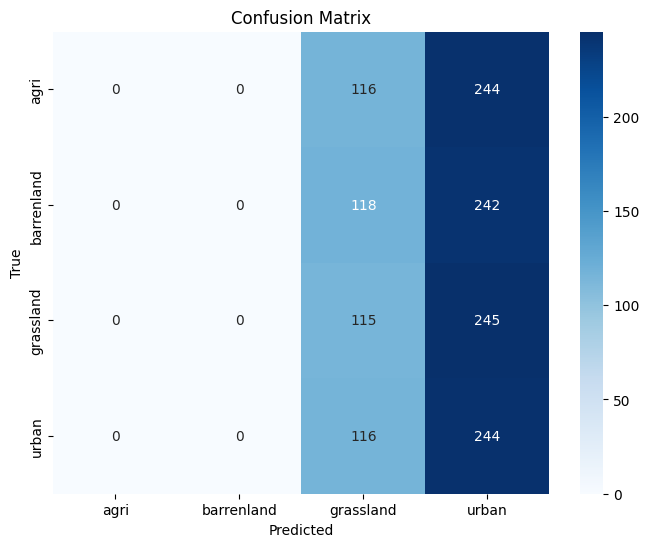

In [ ]:
# Make predictions on the validation dataset
predictions = model.predict(validation_generator)
predicted_labels = np.argmax(predictions, axis=1)
  # Convert probabilities to binary predictions (0 or 1)
true_labels = validation_generator.classes

# Check class indices
print("Class Indices in validation_generator.classes:", np.unique(true_labels))

# Check class labels
class_labels = ["agri", "barrenland", "grassland", "urban"]  # Replace with your actual class labels

print("Class Labels:", class_labels)

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Check class labels in the heatmap
print("Class Labels in Heatmap:", plt.xticks()[1])

In [ ]:
print(classification_report(true_labels, predicted_labels, target_names=class_labels))

              precision    recall  f1-score   support

        agri       0.00      0.00      0.00       360
  barrenland       0.00      0.00      0.00       360
   grassland       0.25      0.32      0.28       360
       urban       0.25      0.68      0.37       360

    accuracy                           0.25      1440
   macro avg       0.12      0.25      0.16      1440
weighted avg       0.12      0.25      0.16      1440



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Prediction Test

In [ ]:
import os
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
import numpy as np

#model = keras.models.load_model('/content/RGB_model.h5')

In [ ]:
labels = ["agri", "barrenland", "grassland", "urban"]

In [ ]:
import os
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
labels = ["agri", "barrenland", "grassland", "urban"]
# Load the pre-trained model
model = keras.models.load_model('/content/drive/MyDrive/SAR_RGB_models/RGB_model_100.keras')

# Define the base directory for test images
base_dir = "/content/drive/MyDrive/SAR_RGB/RGB/test"

# Initialize a dictionary to count correct predictions for each class
correct_predictions = {
    "agri": 0,
    "barrenland": 0,
    "grassland": 0,
    "urban": 0
}

# Define target image size
img_width, img_height = 224, 224  # Example dimensions, adjust as necessary

# Iterate over each category folder
for category in correct_predictions.keys():
    category_dir = Path(base_dir) / category
    images = category_dir.glob('*.png')

    # Process each image in the category folder
    for image in images:
        # Load and preprocess the image
        img = load_img(image, target_size=(img_width, img_height))
        img_array = img_to_array(img)
        img_array = np.array([img_array]) / 255  # Create batch axis
        predictions = model.predict(img_array)

        # Extract the predicted class index (assuming a softmax output)
        predicted_class_index = np.argmax(predictions[0])
        predicted_class = labels[predicted_class_index]

        # Check if the prediction is correct
        if predicted_class == category:
            correct_predictions[category] += 1

# Print the count of correct predictions for each class
for category, count in correct_predictions.items():
    print(f"Correct predictions for {category} class: {count}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━

## Prueba galaxia

In [ ]:
folder_dir = "/content/drive/MyDrive/SAR_RGB/SAR/test"

# Initialize variables to count correct guesses
correct_positive = 0
correct_negative = 0

# Iterate over files in the directory
images = Path(folder_dir).glob('*.png')
for image in images:
    img = keras.preprocessing.image.load_img(image, target_size=(img_width, img_height))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = np.array([img_array]) / 255  # Create batch axis
    predictions = model.predict(img_array)

    # Extract the probability of the positive class (index 1)
    positive_probability = predictions[0][0]

    # Extract true label from the image file name
    true_label = image.stem.split('_')[1]  # Modify this line based on your file naming convention

    # Check if the prediction is correct
    if positive_probability > 0.65 and true_label == "Face-on":
        correct_positive += 1
    elif positive_probability <= 0.65 and true_label == "Edge-on":
        correct_negative += 1

# Print the count of correct predictions
print(f"Correct predictions for Face-on class: {correct_positive}")
print(f"Correct predictions for Edge-on class: {correct_negative}")

Correct predictions for Face-on class: 0
Correct predictions for Edge-on class: 0


In [ ]:
folder_dir ="/content/drive/MyDrive/SAR_RGB/RGB/test"

threshold = 0.65
# iterate over files in
# that directory
images= Path(folder_dir).glob('*.png')
for image in images:
    img = keras.preprocessing.image.load_img(image, target_size=(img_width, img_height))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = np.array([img_array])/255  # Create batch axis
    predictions = model.predict(img_array)
    # Extract the probability of the positive class (index 1)
   # Check if predictions array has only one element
    if predictions.ndim == 1:
        positive_probability = predictions[0]  # Assuming predictions is a single probability
    else:
        positive_probability = predictions[0][0]  # Assuming predictions is a 2D array with shape (1, 1)

    # Apply thresholding to make a binary decision
    if positive_probability > threshold:
        print(image, "Face-on")
    else:
        print(image, "Edge-on")